Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for LassoNet with cross-validation...


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:31<00:00,  6.38s/it]



Best Parameters (cross-validation):
Best Lambda: 74.86883190013424
Best Cross-Validated F1-Score: 0.8526

Test Set Results:
Accuracy: 0.8526

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.83      0.04      0.07       129

    accuracy                           0.85       848
   macro avg       0.84      0.52      0.50       848
weighted avg       0.85      0.85      0.79       848



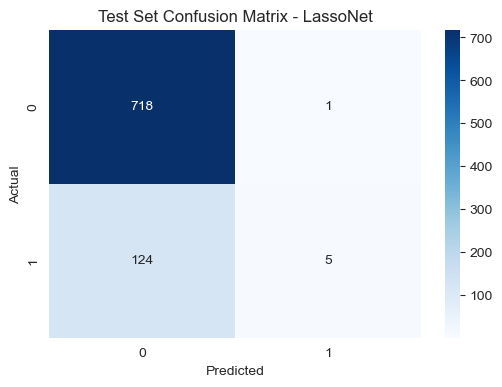

X_train shape: (3392, 15)
X_test shape: (848, 15)

Feature Selection Path (Lambda vs. Coefficients):


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:29<00:00,  5.96s/it]


AttributeError: 'HistoryItem' object has no attribute 'coef_'

In [7]:
# --- 03_lasso_net_classifier.ipynb ---

import numpy as np
import pandas as pd
from lassonet import LassoNetClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# 2. Normalize the Data (if not done already)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}\n")

# 3. Initialize and train the LassoNet model with Cross-validation
print("Setting up Grid Search for LassoNet with cross-validation...")
model = LassoNetClassifierCV()

# Fit the model with cross-validation on the training data
model.fit(X_train_scaled, y_train)

# Get the best lambda from cross-validation
print("\nBest Parameters (cross-validation):")
print(f"Best Lambda: {model.best_lambda_}")
print(f"Best Cross-Validated F1-Score: {model.best_cv_score_:.4f}\n")

# 4. Evaluate the best model on the test set
y_test_pred = model.predict(X_test_scaled)

print("Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# 5. Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix - LassoNet")
plt.show()

# 6. Feature Importance and Interpretation

# Assuming X_train_columns is available (i.e., feature names)
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Convert numpy arrays back to DataFrames and assign columns
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

# Now X_train and X_test have proper column names, and you can access X_train.columns
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 6. Feature Selection Path and Coefficient Visualization
print("Feature Selection Path (Lambda vs. Coefficients):")

# Retrieve all models and paths from LassoNet
path = model.path(X_train_scaled, y_train, return_state_dicts=True)

# Extract lambda values and coefficients over the regularization path
lambdas = [p.lambda_ for p in path]
coefficients_path = [p.coef_ for p in path]

# Get the list of features (using the same order as in X_train)
features = X_train.columns

# Plot Feature Coefficients across Regularization Path (Lambda values)
plt.figure(figsize=(12, 6))

for i, feature in enumerate(features):
    feature_coeffs = [coef[i] for coef in coefficients_path]
    plt.plot(lambdas, feature_coeffs, label=feature)

plt.xscale('log')  # Log scale for lambda
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Feature Coefficients')
plt.title('Feature Coefficients Path (Lambda vs. Coefficients)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



# 7. Save the best model to disk
os.makedirs("../models", exist_ok=True)
model_path = "../models/lassonet_best_model.pkl"
joblib.dump(model, model_path)
print(f"Best LassoNet model saved to {model_path}")

